<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/DeepLearningCNN/blob/main/torchvisionmodelscompile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

Neste tutorial, daremos uma olhada em como ajustar e extrair recursos dos modelos torchvision, todos os quais foram pré-treinados no conjunto de dados Imagenet de 1000 classes. Este tutorial dará uma visão detalhada de como trabalhar com várias arquiteturas CNN modernas e criará uma intuição para ajustar qualquer modelo PyTorch. Como cada arquitetura de modelo é diferente, não existe um código de ajuste fino padrão que funcione em todos os cenários. Em vez disso, o pesquisador deve olhar para a arquitetura existente e fazer ajustes personalizados para cada modelo.

Neste documento, realizaremos dois tipos de aprendizagem por transferência: ajuste fino e extração de recursos. No ajuste fino, começamos com um modelo pré-treinado e atualizamos todos os parâmetros do modelo para nossa nova tarefa, em essência, retreinamos todo o modelo. Na extração de recursos, começamos com um modelo pré-treinado e apenas atualizamos os pesos das camadas finais das quais derivamos as previsões. É chamado de extração de recursos porque usamos o CNN pré-treinado como um extrator de recursos fixo e apenas alteramos a camada de saída. Para obter mais informações técnicas sobre transferência de aprendizagem.

Em geral, os dois métodos de aprendizagem por transferência seguem as mesmas etapas:

-  Inicialize o modelo pré-treinado.
- Remodele a (s) camada (s) final (is) para ter o mesmo número de saídas que o número de classes no novo conjunto de dados.
-  Defina para o algoritmo de otimização quais parâmetros queremos atualizar durante o treinamento.
-  Execute a etapa de treinamento.




In [2]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


Inputs
------

Aqui estão todos os parâmetros a serem alterados durante a execução. Usaremos o conjunto de dados hymenoptera_data que pode ser baixado aqui. Este conjunto de dados contém duas classes, abelhas e formigas, e é estruturado de forma que possamos usar o conjunto de dados ImageFolder, em vez de escrever nosso próprio conjunto de dados personalizado. Baixe os dados e defina a entrada data_dir para o diretório raiz do conjunto de dados. A entrada model_name é o nome do modelo que você deseja usar e deve ser selecionado nesta lista:

[resnet, alexnet, vgg, squeezenet, densenet, início]
As outras entradas são as seguintes: num_classes é o número de classes no conjunto de dados, batch_size é o tamanho do lote usado para treinamento e pode ser ajustado de acordo com a capacidade de sua máquina, num_epochs é o número de épocas de treinamento que queremos executar e feature_extract é um booleano que define se estamos ajustando ou extraindo recursos. Se feature_extract = False, o modelo é ajustado e todos os parâmetros do modelo são atualizados. Se feature_extract = True, apenas os parâmetros da última camada são atualizados, os outros permanecem fixos.



In [3]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

Funções auxiliares
----------------

Antes de escrevermos o código para ajustar os modelos, vamos definir algumas funções auxiliares.

Treinando modelo e Validando Codigo
----------------------------------

A função train_model lida com o treinamento e validação de um determinado modelo. Como entrada, é necessário um modelo PyTorch, um dicionário de carregadores de dados, uma função de perda, um otimizador, um número especificado de épocas para treinar e validar e um sinalizador booleano para quando o modelo é um modelo Inception. O sinalizador is_inception é usado para acomodar o modelo Inception v3, já que essa arquitetura usa uma saída auxiliar e a perda geral do modelo respeita a saída auxiliar e a saída final, conforme descrito aqui. A função treina para o número especificado de épocas e, após cada época, executa uma etapa de validação completa. Ele também controla o modelo de melhor desempenho (em termos de precisão de validação) e, no final do treinamento, retorna o modelo de melhor desempenho. Após cada época, as precisões de treinamento e validação são impressas.




In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Definir o atributo .requires_grad dos parâmetros do modelo
----------------------------------------------

Esta função auxiliar define o atributo `` .requires_grad`` do
parâmetros no modelo para False quando estamos extraindo recursos. Por
padrão, quando carregamos um modelo pré-treinado, todos os parâmetros têm
`` .requires_grad = True``, o que é bom se estivermos treinando do zero
ou ajuste fino. No entanto, se estamos extraindo recursos e apenas queremos
computar gradientes para a camada recém-inicializada, então queremos todos
os outros parâmetros não requerem gradientes. Isso vai fazer mais sentido
mais tarde.




In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Inicializar e remodelar as redes
-----------------------------------

Agora, para a parte mais interessante. Aqui é onde lidamos com a remodelação
de cada rede. Observe, este não é um procedimento automático e é único
para cada modelo. Lembre-se, a camada final de um modelo CNN, que muitas vezes é
vezes uma camada FC, tem o mesmo número de nós que o número de saída
classes no conjunto de dados. Uma vez que todos os modelos foram pré-treinados em
Imagenet, todos eles têm camadas de saída de tamanho 1000, um nó para cada
classe. O objetivo aqui é remodelar a última camada para ter o mesmo
número de entradas como antes, E para ter o mesmo número de saídas que
o número de classes no conjunto de dados. Nas seções a seguir, iremos
discuta como alterar a arquitetura de cada modelo individualmente. Mas
primeiro, há um detalhe importante a respeito da diferença entre
ajuste fino e extração de recursos.

Ao extrair recursos, queremos apenas atualizar os parâmetros do
última camada, ou em outras palavras, queremos apenas atualizar os parâmetros para
a (s) camada (s) que estamos remodelando. Portanto, não precisamos calcular o
gradientes dos parâmetros que não estamos alterando, portanto, para eficiência
definimos o atributo .requires_grad como False. Isso é importante porque
por padrão, este atributo é definido como True. Então, quando inicializamos o
nova camada e por padrão os novos parâmetros têm `` .requires_grad = True``
portanto, apenas os parâmetros da nova camada serão atualizados. Quando estamos
no ajuste fino, podemos deixar todos os .required_grad configurados para o padrão
de verdade.

Finalmente, observe que inception_v3 requer que o tamanho da entrada seja
(299.299), enquanto todos os outros modelos esperam (224.224).

Resnet
------

Resnet foi apresentado no artigo [Deep Residual Learning for Image
Reconhecimento] (https://arxiv.org/abs/1512.03385). Existem vários
variantes de tamanhos diferentes, incluindo Resnet18, Resnet34, Resnet50,
Resnet101 e Resnet152, todos disponíveis em torchvision
modelos. Aqui usamos Resnet18, pois nosso conjunto de dados é pequeno e tem apenas dois
Aulas. Quando imprimimos o modelo, vemos que a última camada é totalmente
camada conectada conforme mostrado abaixo:

    (fc): Linear (in_features = 512, out_features = 1000, bias = True)

Assim, devemos reinicializar `` model.fc`` para ser uma camada linear com 512
recursos de entrada e 2 recursos de saída com:

    model.fc = nn.Linear (512, num_classes)

Alexnet
-------

Alexnet foi apresentado no artigo [ImageNet Classification with Deep
Neural convolucional
Redes] (https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
e foi a primeira CNN muito bem-sucedida no conjunto de dados ImageNet. Quando nós
imprimir a arquitetura do modelo, vemos que a saída do modelo vem do 6º
camada do classificador

    (classificador): Sequencial (
       ...
       (6): Linear (in_features = 4096, out_features = 1000, bias = True)
    )

Para usar o modelo com nosso conjunto de dados, reinicializamos esta camada como

    model.classifier [6] = nn.Linear (4096, num_classes)

VGG
---

VGG foi apresentado no artigo [Very Deep Convolutional Networks for
Reconhecimento de imagem em grande escala] (https://arxiv.org/pdf/1409.1556.pdf).
A Torchvision oferece oito versões do VGG com vários comprimentos e alguns
que possuem camadas de normalização em lote. Aqui usamos VGG-11 com lote
normalização. A camada de saída é semelhante a Alexnet, ou seja,

    (classificador): Sequencial (
       ...
       (6): Linear (in_features = 4096, out_features = 1000, bias = True)
    )

Portanto, usamos a mesma técnica para modificar a camada de saída

    model.classifier [6] = nn.Linear (4096, num_classes)

Squeezenet
----------

A arquitetura Squeeznet é descrita no artigo [SqueezeNet:
Precisão no nível do AlexNet com 50x menos parâmetros e tamanho do modelo inferior a 0,5 MB] (https://arxiv.org/abs/1602.07360) e usa uma saída diferente
estrutura do que qualquer um dos outros modelos mostrados aqui. Torchvision tem dois
versões do Squeezenet, usamos a versão 1.0. A saída vem de um 1x1
camada convolucional que é a 1ª camada do classificador:

    (classificador): Sequencial (
       (0): Desistência (p = 0,5)
       (1): Conv2d (512, 1000, kernel_size = (1, 1), passo = (1, 1))
       (2): ReLU (no local)
       (3): AvgPool2d (kernel_size = 13, passo = 1, preenchimento = 0)
    )

Para modificar a rede, reinicializamos a camada Conv2d para ter um
mapa de recursos de saída de profundidade 2 como

    model.classifier [1] = nn.Conv2d (512, num_classes, kernel_size = (1,1), passo = (1,1))

Densenet
--------

Densenet foi apresentado no artigo [Densely Connected Convolutional
Networks] (https://arxiv.org/abs/1608.06993). Torchvision tem quatro
variantes de Densenet, mas aqui usamos apenas Densenet-121. A camada de saída
é uma camada linear com 1024 recursos de entrada:

    (classificador): Linear (in_features = 1024, out_features = 1000, bias = True)

Para remodelar a rede, reinicializamos a camada linear do classificador como

    model.classifier = nn.Linear (1024, num_classes)

Inception v3
------------

Finalmente, o Inception v3 foi descrito pela primeira vez em [Repensando o Inception
Arquitetura para Computador
Visão] (https://arxiv.org/pdf/1512.00567v1.pdf). Esta rede é
exclusivo




In [6]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

Ler os dados
---------

Agora que sabemos qual deve ser o tamanho da entrada, podemos inicializar as transformações de dados, os conjuntos de dados de imagens e os carregadores de dados. Observe que os modelos foram pré-treinados com os valores de normalização embutidos em código.



In [7]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2021-11-27 00:48:07--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.249.93.14, 13.249.93.46, 13.249.93.56, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.93.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  48.5MB/s    in 0.9s    

2021-11-27 00:48:09 (48.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/tr

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cria o Otimizador
--------------------

Agora que a estrutura do modelo está correta, a etapa final para o ajuste fino
e a extração de recursos é criar um otimizador que apenas atualiza o
parâmetros desejados. Lembre-se que depois de carregar o modelo pré-treinado, mas
antes de remodelar, se `` feature_extract = True`` nós definimos manualmente todos os
atributos `` .requires_grad`` do parâmetro para False. Então o
os parâmetros da camada reinicializada têm `` .requires_grad = True`` por
predefinição. Agora sabemos que * todos os parâmetros que têm
.requires_grad = True deve ser otimizado. * A seguir, fazemos uma lista de tais
parâmetros e insira esta lista para o construtor do algoritmo SGD.

Para verificar isso, verifique os parâmetros impressos para aprender. Quando
ajuste fino, esta lista deve ser longa e incluir todo o modelo
parâmetros. No entanto, ao extrair recursos, esta lista deve ser curta
e inclui apenas os pesos e inclinações das camadas remodeladas.



In [9]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


Executar etapa de treinamento e validação
--------------------------------

Finalmente, a última etapa é configurar a perda para o modelo e, em seguida, executar o
função de treinamento e validação para o número definido de épocas. Perceber,
dependendo do número de épocas, esta etapa pode demorar um pouco em uma CPU.
Além disso, a taxa de aprendizagem padrão não é ideal para todos os modelos, então
para atingir a precisão máxima, seria necessário ajustar para cada modelo
separadamente.




In [10]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5338 Acc: 0.7213
val Loss: 0.4960 Acc: 0.8039

Epoch 1/14
----------
train Loss: 0.2541 Acc: 0.8934
val Loss: 0.3553 Acc: 0.8824

Epoch 2/14
----------
train Loss: 0.2997 Acc: 0.8689
val Loss: 0.3192 Acc: 0.9020

Epoch 3/14
----------
train Loss: 0.2138 Acc: 0.9221
val Loss: 0.3243 Acc: 0.9150

Epoch 4/14
----------
train Loss: 0.2067 Acc: 0.9139
val Loss: 0.4091 Acc: 0.8693

Epoch 5/14
----------
train Loss: 0.2002 Acc: 0.9098
val Loss: 0.3791 Acc: 0.9020

Epoch 6/14
----------
train Loss: 0.1772 Acc: 0.9180
val Loss: 0.3282 Acc: 0.9346

Epoch 7/14
----------
train Loss: 0.1422 Acc: 0.9385
val Loss: 0.3315 Acc: 0.9216

Epoch 8/14
----------
train Loss: 0.1342 Acc: 0.9426
val Loss: 0.3860 Acc: 0.9085

Epoch 9/14
----------
train Loss: 0.1702 Acc: 0.9180
val Loss: 0.3738 Acc: 0.9281

Epoch 10/14
----------
train Loss: 0.1783 Acc: 0.9344
val Loss: 0.3176 Acc: 0.9150

Epoch 11/14
----------
train Loss: 0.1214 Acc: 0.9549
val Loss: 0.3451 Acc: 0.9216

Epoch 12/14
----------
t

Comparação com modelo treinado do zero
------------------------------------------

Apenas por diversão, vamos ver como o modelo aprende se não usarmos transferência
Aprendendo. O desempenho do ajuste fino vs. extração de recursos depende
em grande parte no conjunto de dados, mas em geral ambos os métodos de aprendizagem de transferência
produzir resultados favoráveis em termos de tempo de treinamento e precisão geral
versus um modelo treinado do zero.




Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7066 Acc: 0.4385
val Loss: 0.6931 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.6932 Acc: 0.4713
val Loss: 0.6931 Acc: 0.4575

Epoch 2/14
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 3/14
----------
train Loss: 0.6931 Acc: 0.5205
val Loss: 0.6931 Acc: 0.4575

Epoch 4/14
----------
train Loss: 0.6931 Acc: 0.4754
val Loss: 0.6931 Acc: 0.4575

Epoch 5/14
----------
train Loss: 0.6930 Acc: 0.5574
val Loss: 0.6931 Acc: 0.4575

Epoch 6/14
----------
train Loss: 0.6932 Acc: 0.5082
val Loss: 0.6931 Acc: 0.4575

Epoch 7/14
----------
train Loss: 0.6930 Acc: 0.5287
val Loss: 0.6931 Acc: 0.4575

Epoch 8/14
----------
train Loss: 0.6930 Acc: 0.5164
val Loss: 0.6931 Acc: 0.4575

Epoch 9/14
----------
train Loss: 0.6930 Acc: 0.5205
val Loss: 0.6931 Acc: 0.4575

Epoch 10/14
----------
train Loss: 0.6929 Acc: 0.5164
val Loss: 0.6931 Acc: 0.4575

Epoch 11/14
----------
train Loss: 0.6928 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 12/14
----------
t

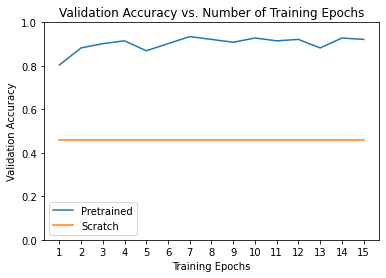

In [11]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()